In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

/bin/bash: nvcc: command not found
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.6.0 True
0.22.1


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [4]:
from torchvision import datasets, models, transforms
import torch.optim as optim

if torch.cuda.is_available():
    torch.cuda.init()
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    cuda = torch.device('cuda')
    cuda0 = torch.device('cuda:0')
    print(cuda0)

0
1
0
0
cuda:0


/home/user/anaconda3/envs/python37/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [5]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [6]:
torch.cuda.empty_cache()

In [7]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [8]:
import os.path as osp
import numpy as np
from PIL import Image
import skimage
from skimage import io
print(skimage.__version__)

0.18.3


In [9]:
import mmcv

In [10]:
classes = ['background', 'human']
palette = [[0,0,0], [255,0,0]]
class_weight = [1.0, 6.0] # 0.05 human pixels 

In [11]:
import os.path as osp
import mmcv
import numpy as np
from PIL import Image

from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset


@DATASETS.register_module()
class ADE20KDataset01(CustomDataset):
    """ADE20K dataset.
    In segmentation map annotation for ADE20K, 0 stands for background, which
    is not included in 150 categories. ``reduce_zero_label`` is fixed to True.
    The ``img_suffix`` is fixed to '.jpg' and ``seg_map_suffix`` is fixed to
    '.png'.
    """
    CLASSES = classes
    PALETTE = palette

    def __init__(self, **kwargs):
        super(ADE20KDataset01, self).__init__(
            img_suffix='.jpg',
            seg_map_suffix='.png',
            reduce_zero_label=False,
            **kwargs)
        assert osp.exists(self.img_dir)

    def results2img(self, results, imgfile_prefix, to_label_id, indices=None):
        if indices is None:
            indices = list(range(len(self)))

        mmcv.mkdir_or_exist(imgfile_prefix)
        result_files = []
        for result, idx in zip(results, indices):

            filename = self.img_infos[idx]['filename']
            basename = osp.splitext(osp.basename(filename))[0]

            png_filename = osp.join(imgfile_prefix, f'{basename}.png')

            output = Image.fromarray(result.astype(np.uint8))
            output.save(png_filename)
            result_files.append(png_filename)

        return result_files

    def format_results(self,
                       results,
                       imgfile_prefix,
                       to_label_id=True,
                       indices=None):
        
        if indices is None:
            indices = list(range(len(self)))

        assert isinstance(results, list), 'results must be a list.'
        assert isinstance(indices, list), 'indices must be a list.'

        result_files = self.results2img(results, imgfile_prefix, to_label_id,
                                        indices)
        return result_files

In [12]:
from mmcv import Config
cfg = Config.fromfile('../configs/bisenetv1/bisenetv1_r18-d32_lr5e-3_4x4_512x512_160k_coco-stuff164k.py')

In [13]:
data_root = '../data/ade/ADEChallengeData2016'
img_dir = 'images-binary'
ann_dir = 'binary-labels'

In [14]:
context_channels=(128, 256, 512)
spatial_channels=(64, 64, 64, 128)

In [15]:
decode_head_loss_weight = 0.3
auxiliary_head_loss_weight = decode_head_loss_weight*0.4

In [16]:
norm_config_type = 'BN'

In [17]:
from mmseg.apis import set_random_seed
# Since we use ony one GPU, BN is used instead of BN
cfg.norm_cfg = dict(type=norm_config_type, requires_grad=True)  # Segmentation usually uses SyncBN
# model settings
cfg.model = dict(
    type='EncoderDecoder', # Name of segmentor
    pretrained=None,
    backbone=dict(
        type='BiSeNetV1', # The type of backbone.
        in_channels=3,
        context_channels=context_channels,
        spatial_channels=spatial_channels,
        out_indices=(0, 1, 2),
        out_channels=256,
        backbone_cfg=dict(
            type='ResNet',
            in_channels=3,
            depth=18,
            num_stages=4,
            out_indices=(0, 1, 2, 3),
            dilations=(1, 1, 1, 1),
            strides=(1, 2, 2, 2),
            norm_cfg=cfg.norm_cfg,
            norm_eval=False,
            style='pytorch',
            contract_dilation=True),
        norm_cfg=cfg.norm_cfg,
        align_corners=False,
        init_cfg=None),
    decode_head=dict(
        type='FCNHead',
        in_channels=256,
        in_index=0,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=len(classes),
        norm_cfg=cfg.norm_cfg,
        align_corners=False,
        loss_decode=[
            dict(
                type='CrossEntropyLoss',
                loss_name='loss_ce',
                use_sigmoid=False,
                loss_weight=decode_head_loss_weight,
                #class_weight=class_weight
            ),
            dict(
                type='DiceLoss',
                loss_name='loss_dice',
                use_sigmoid=False,
                loss_weight=decode_head_loss_weight,
                class_weight=class_weight
            )
        ]
    ),
    auxiliary_head=[
        dict(
            type='FCNHead', # Type of auxiliary head. Please refer to mmseg/models/decode_heads for available options.
            in_channels=128, # Input channel of auxiliary head.
            channels=64, # The intermediate channels of decode head.
            num_convs=1, # Number of convs in FCNHead. It is usually 1 in auxiliary head.
            num_classes=len(classes), # Number of segmentation class. Usually 19 for cityscapes, 21 for VOC, 150 for ADE20k.
            in_index=1, # The index of feature map to select.
            norm_cfg=cfg.norm_cfg, # The configuration of norm layer.
            concat_input=False, # The configuration of norm layer.
            align_corners=False, # The align_corners argument for resize in decoding.
            loss_decode=[ 
                dict( # Config of loss function for the decode_head.
                    type='CrossEntropyLoss', # Type of loss used for segmentation.
                    loss_name='loss_ce',
                    use_sigmoid=False, # Whether use sigmoid activation for segmentation.
                    loss_weight=auxiliary_head_loss_weight, # Loss weight of auxiliary head, which is usually 0.4 of decode head.
                    #class_weight=class_weight
                ),
                dict( # Config of loss function for the decode_head.
                    type='DiceLoss', # Type of loss used for segmentation.
                    loss_name='loss_dice',
                    use_sigmoid=False, # Whether use sigmoid activation for segmentation.
                    loss_weight=auxiliary_head_loss_weight, # Loss weight of auxiliary head, which is usually 0.4 of decode head.
                    class_weight=class_weight
                )
            ]
        ),
        dict(
            type='FCNHead',
            in_channels=128,
            channels=64,
            num_convs=1,
            num_classes=len(classes),
            in_index=2,
            norm_cfg=cfg.norm_cfg,
            concat_input=False,
            align_corners=False,
            loss_decode=[ 
                dict( # Config of loss function for the decode_head.
                    type='CrossEntropyLoss', # Type of loss used for segmentation.
                    loss_name='loss_ce',
                    use_sigmoid=False, # Whether use sigmoid activation for segmentation.
                    loss_weight=auxiliary_head_loss_weight, # Loss weight of auxiliary head, which is usually 0.4 of decode head.
                    #class_weight=class_weight
                ),
                dict( # Config of loss function for the decode_head.
                    type='DiceLoss', # Type of loss used for segmentation.
                    loss_name='loss_dice',
                    use_sigmoid=False, # Whether use sigmoid activation for segmentation.
                    loss_weight=auxiliary_head_loss_weight, # Loss weight of auxiliary head, which is usually 0.4 of decode head.
                    class_weight=class_weight
                )
            ]
        )
    ],
    # model training and testing settings
    train_cfg=dict(),  # train_cfg is just a place holder for now.
    test_cfg=dict(mode='whole') # The test mode, options are 'whole' and 'sliding'. 'whole': whole image fully-convolutional test. 'sliding': sliding crop window on the image.
)  

In [18]:
############### start dataset 
cfg.dataset_type = 'ADE20KDataset01'  # Dataset type, this will be used to define the dataset.
cfg.data_root = data_root  # Root path of data.
cfg.img_norm_cfg = dict(  # Image normalization config to normalize the input images.
    mean=[123.675, 116.28, 103.53],  # Mean values used to pre-training the pre-trained backbone models.
    std=[58.395, 57.12, 57.375],  # Standard variance used to pre-training the pre-trained backbone models.
    to_rgb=True)  # The channel orders of image used to pre-training the pre-trained backbone models.
cfg.crop_size = (512, 512)  # The crop size during training.

cfg.train_pipeline = [  # Training pipeline.
    dict(type='LoadImageFromFile'),  # First pipeline to load images from file path.
    dict(type='LoadAnnotations', reduce_zero_label=False),  # Second pipeline to load annotations for current image.
    dict(type='Resize',  # Augmentation pipeline that resize the images and their annotations.
        img_scale=(2048, 512),  # The largest scale of image.
        ratio_range=(0.5, 2.0)), # The augmented scale range as ratio.
    dict(type='RandomCrop',  # Augmentation pipeline that randomly crop a patch from current image.
        crop_size=cfg.crop_size,  # The crop size of patch.
        cat_max_ratio=0.75),  # The max area ratio that could be occupied by single category.
    dict(
        type='RandomFlip',  # Augmentation pipeline that flip the images and their annotations
        flip_ratio=0.5),  # The ratio or probability to flip
    dict(type='PhotoMetricDistortion'),  # Augmentation pipeline that distort current image with several photo metric methods.
    dict(
        type='Normalize',  # Augmentation pipeline that normalize the input images
        **cfg.img_norm_cfg),
    dict(type='Pad',  # Augmentation pipeline that pad the image to specified size.
        size=cfg.crop_size,  # The output size of padding.
        pad_val=0,  # The padding value for image.
        seg_pad_val=255),  # The padding value of 'gt_semantic_seg'.
    dict(type='DefaultFormatBundle'),  # Default format bundle to gather data in the pipeline
    dict(type='Collect',  # Pipeline that decides which keys in the data should be passed to the segmentor
        keys=['img', 'gt_semantic_seg'])
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),  # First pipeline to load images from file path
    dict(
        type='MultiScaleFlipAug',  # An encapsulation that encapsulates the test time augmentations
        img_scale=(2048, 512),  # Decides the largest scale for testing, used for the Resize pipeline
        flip=False,  # Whether to flip images during testing
        transforms=[
            dict(type='Resize',  # Use resize augmentation
                 keep_ratio=True),  # Whether to keep the ratio between height and width, the img_scale set here will be suppressed by the img_scale set above.
            dict(type='RandomFlip'),  # Thought RandomFlip is added in pipeline, it is not used when flip=False
            dict(
                type='Normalize',  # Normalization config, the values are from img_norm_cfg
                 **cfg.img_norm_cfg),
            dict(type='ImageToTensor', # Convert image to tensor
                keys=['img']),
            dict(type='Collect', # Collect pipeline that collect necessary keys for testing.
                keys=['img'])
        ])
]
cfg.data = dict(
    samples_per_gpu=16,
    workers_per_gpu=16,
    train=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/training',
        ann_dir=f'{ann_dir}/training',
        pipeline=cfg.train_pipeline),
    val=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/validation',
        ann_dir=f'{ann_dir}/validation',
        pipeline=cfg.test_pipeline),
    test=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        img_dir=f'{img_dir}/validation',
        ann_dir=f'{ann_dir}/validation',
        pipeline=cfg.test_pipeline))
############ end dataset

In [19]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]
#print(datasets[0].CLASSES)
print(len(datasets[0].CLASSES))

2022-04-01 10:46:49,735 - mmseg - INFO - Loaded 5569 images


2


In [20]:
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = len(datasets[0].CLASSES)
cfg.model.auxiliary_head[0].num_classes = len(datasets[0].CLASSES)
cfg.model.auxiliary_head[1].num_classes = len(datasets[0].CLASSES)

In [21]:
# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/testv1.Training_Tricks.160000iter'

############ start default runtime
cfg.log_config = dict(  # config to register logger hook
    interval=50,  # Interval to print the log
    hooks=[
        dict(type='TensorboardLoggerHook'),  # The Tensorboard logger is also supported
        dict(type='TextLoggerHook', by_epoch=False)
    ])
cfg.dist_params = dict(backend='nccl')  # Parameters to setup distributed training, the port can also be set.
cfg.log_level = 'INFO'  # The level of logging.
cfg.load_from = './work_dirs/testv1.Training_Tricks.160000iter/iter_160000.pth'  # load models as a pre-trained model from a given path. This will not resume training.
cfg.resume_from = './work_dirs/testv1.Training_Tricks.160000iter/iter_160000.pth'  # Resume checkpoints from a given path, the training will be resumed from the iteration when the checkpoint's is saved.
cfg.workflow = [('train', 1)]  # Workflow for runner. [('train', 1)] means there is only one workflow and the workflow named 'train' is executed once. The workflow trains the model by 40000 iterations according to the `runner.max_iters`.
cfg.cudnn_benchmark = True  # Whether use cudnn_benchmark to speed up, which is fast for fixed input size.
############ end default runtime

############ start schedule
cfg.optimizer = dict(  # Config used to build optimizer, support all the optimizers in PyTorch whose arguments are also the same as those in PyTorch
    type='SGD',  # Type of optimizers, refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/optimizer/default_constructor.py#L13 for more details
    lr=0.005,  # Learning rate of optimizers, see detail usages of the parameters in the documentation of PyTorch
    momentum=0.9,  # Momentum
    weight_decay=0.0005,
    paramwise_cfg=dict(
        custom_keys=dict(head=dict(lr_mult=10.0)))
)
cfg.optimizer_config = dict()  # Config used to build the optimizer hook, refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/optimizer.py#L8 for implementation details.
lr_config = dict(
    policy='poly',  # The policy of scheduler, also support Step, CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9.
    power=0.9,  # The power of polynomial decay.
    min_lr=0.00001,  # The minimum learning rate to stable the training.
    by_epoch=False,
    warmup='linear',
    warmup_iters=1000
)  # Whether count by epoch or not.
cfg.runner=dict(
    type='IterBasedRunner', # Type of runner to use (i.e. IterBasedRunner or EpochBasedRunner)
    max_iters=160000) # Total number of iterations. For EpochBasedRunner use `max_epochs`
cfg.checkpoint_config = dict(  # Config to set the checkpoint hook, Refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/checkpoint.py for implementation.
    by_epoch=False,  # Whether count by epoch or not.
    interval=10000,
    meta=dict(
        CLASSES=classes,
        PALETTE=palette
    )
)
cfg.evaluation = dict(  # The config to build the evaluation hook. Please refer to mmseg/core/evaluation/eval_hook.py for details.
    interval=5000,  # The interval of evaluation.
    metric='mIoU',
    pre_eval=True)  # The evaluation metric.

############ end schedule

In [22]:
# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='BiSeNetV1',
        in_channels=3,
        context_channels=(128, 256, 512),
        spatial_channels=(64, 64, 64, 128),
        out_indices=(0, 1, 2),
        out_channels=256,
        backbone_cfg=dict(
            type='ResNet',
            in_channels=3,
            depth=18,
            num_stages=4,
            out_indices=(0, 1, 2, 3),
            dilations=(1, 1, 1, 1),
            strides=(1, 2, 2, 2),
            norm_cfg=dict(type='BN', requires_grad=True),
            norm_eval=False,
            style='pytorch',
            contract_dilation=True),
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        init_cfg=None),
    decode_head=dict(
        type='FCNHead',
        in_channels=256,
        in_index=0,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropo

In [23]:
# Build the detector
model = build_segmentor(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

In [24]:
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.PALETTE = datasets[0].PALETTE

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [25]:
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-04-01 10:46:50,925 - mmseg - INFO - Loaded 610 images
2022-04-01 10:46:50,926 - mmseg - INFO - load checkpoint from local path: ./work_dirs/testv1.Training_Tricks.160000iter/iter_160000.pth
2022-04-01 10:46:50,973 - mmseg - INFO - resumed from epoch: 1, iter 159999
2022-04-01 10:46:50,974 - mmseg - INFO - Start running, host: user@ESWS-VT02-01, work_dir: /home/user/workspace/github/mmsegmentation/demo/work_dirs/testv1.Training_Tricks.160000iter
2022-04-01 10:46:50,974 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TensorboardLoggerHook              
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                       

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 610/610, 49.5 task/s, elapsed: 12s, ETA:     0s

2022-04-01 10:47:06,576 - mmseg - INFO - per class results:
2022-04-01 10:47:06,577 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.17 | 98.25 |
|   human    |  60.3 | 79.67 |
+------------+-------+-------+
2022-04-01 10:47:06,577 - mmseg - INFO - Summary:
2022-04-01 10:47:06,577 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.29 | 78.73 | 88.96 |
+-------+-------+-------+
2022-04-01 10:47:06,580 - mmseg - INFO - Iter(val) [610]	aAcc: 0.9729, mIoU: 0.7873, mAcc: 0.8896, IoU.background: 0.9717, IoU.human: 0.6030, Acc.background: 0.9825, Acc.human: 0.7967


In [26]:
# human IoU above 70%


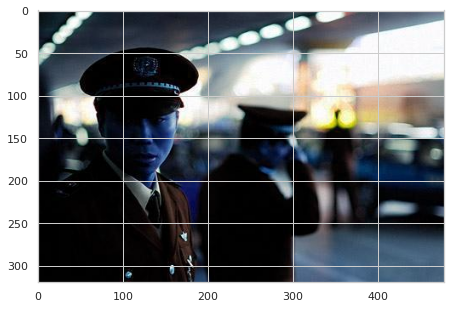

In [27]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/images-binary/validation/ADE_val_00000011.jpg')
plt.imshow(img)

In [28]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/images-binary/validation/ADE_val_00000011.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)

In [29]:
np.asarray(result).max()

1

/home/user/workspace/github/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

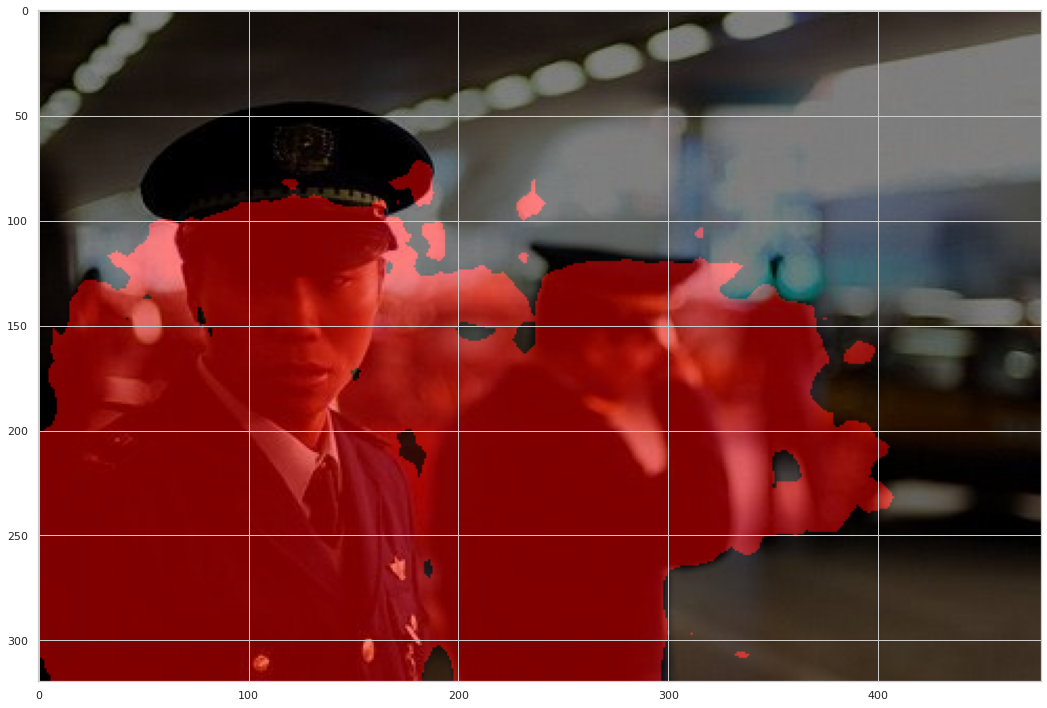

In [30]:
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

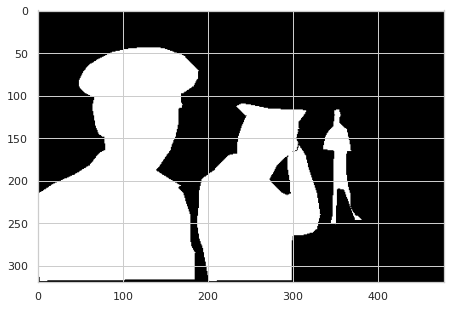

In [31]:
img = mmcv.imread('../data/ade/ADEChallengeData2016/binary-labels/validation/ADE_val_00000011.png')
img[img == 1] = 255
plt.imshow(img, cmap="gray")

In [32]:
img.max()

255

In [33]:
img.min()

0

In [34]:
# print('show video')
# test a video and show the results
video = mmcv.VideoReader('../data/ramp.mp4')

In [35]:
import time

In [36]:
video[1].shape

(1080, 1920, 3)

In [37]:
x = 100

In [38]:
%%time
start = time.time()

for frame in video[:x]: # time - how many frame per sec - metrics acc - IoU
    result = inference_segmentor(model, frame)
    #model.show_result(frame, result)

end = time.time()

CPU times: user 4.32 s, sys: 421 ms, total: 4.74 s
Wall time: 2.18 s


In [39]:
from humanfriendly import format_timespan
aux0 = (end-start)
print("Time:", format_timespan(aux0))
aux1 = aux0/x
print("Time/frame:", format_timespan(aux1))
print("FPS: ", 1/aux1)

Time: 2.18 seconds
Time/frame: 0.02 seconds
FPS:  45.87495987325691


In [40]:
# display the training loss changes
